In [71]:
from copy import deepcopy
from string import punctuation
from random import shuffle
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.tokenize import TweetTokenizer
import gc
from keras.models import Sequential
from keras.layers import Activation,Embedding,MaxPooling1D,LSTM,Bidirectional
from keras.callbacks import EarlyStopping 
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam
from keras.layers.core import Dense, Dropout
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Parameters

#Dictionary size.top Max_word_count words
Max_word_count=300000

max_tweet_length = 80
n_dim=100
batch_size = 64
nb_epochs = 15

In [3]:
#use only smaller set for memory problems
neg_twit_path='data/train_neg.txt'
pos_twit_path='data/train_pos.txt'
test_tweet_path='data/test_data.txt'
test_tweet_only_path='data/test_tweet_data.txt'
neg_twit_cleaned='data/clean/train_neg.txt'
pos_twit_cleaned='data/clean/train_pos.txt'
test_tweet_cleaned='data/clean/test_data.txt'
gloveFile='glove.twitter.27B.100d.txt'

In [4]:
def cleanTweets(tweets):
    
    remove_numbers_start = r'\d+(\w*|\d*)'
    remove_numbers_end = r'(\w*|\d*)\d+'
    remove_hashtags = r'#(\w*|#*|\d*)'
    remove_underscores = r'_(\w*)'
    remove_punctuation = r"[.,;'?():-_!$&%{}~/|]"
    remove_quotation = r'"'
    remove_math_ops = r'[-+.^:,*]'  
    remove_delimeted_words = r'<[^>]+>'
    
    combined_pattern = r'|'.join((remove_numbers_start,remove_numbers_end,remove_hashtags,remove_underscores,remove_quotation,remove_delimeted_words))
    combined_pattern2 = r'|'.join((remove_punctuation,remove_math_ops))
    cleaned_tweets1 = re.sub(combined_pattern,'',tweets)
    cleaned_tweets2 = re.sub(combined_pattern2,'',cleaned_tweets1)
    print("clean tweets: " + str(len(cleaned_tweets2)))
    return cleaned_tweets2

In [5]:
# replaces all words having an instance of a character more than 2 timess
def repl(matchObj):	
    char = matchObj.group(1)
    return "%s%s" % (char, char)

In [6]:
def replaceRepeatingCharacters(tweets):
    pattern = re.compile(r"(\w)\1+")
    corrected_words = pattern.sub(repl,tweets)
    return corrected_words

In [7]:
def loadData(path,inputF, outputTweets):
    print('Loading raw data, cleaning and writing cleaned data...')

    inputSet = path + inputF
    outputSetA = outputTweets
    
    #read data sets
    file = open(inputSet)
    raw_data = file.read()
    print("raw_data:" + str(len(raw_data)))

    
    cleaned_data = cleanTweets(raw_data)

    strip_repeated_chars = replaceRepeatingCharacters(cleaned_data)
    
    
    writeToFile(strip_repeated_chars,outputSetA)


In [9]:
def writeToFile(data,outputSet):
    print("writing to file...")
    result = open(outputSet, 'w')
    if (type(data) is list):
        for item in data:
            result.write("%s\n" % item)
    elif (type(data) is str):
        # remove whitespaces generated by data cleaning
        newform = re.sub(' +',' ',data.lstrip())
        result.write(newform)

In [10]:
#load glove model
def create_glove_model():
    print("Loading Glove Model...")
    f = open(gloveFile,'r')
    glove_model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        glove_model[word] = embedding
    print("Done." + str(len(glove_model)) + " words loaded!")
    return glove_model

In [11]:
#create tokenizer,create dictionary with sequences with same size
#and Y values like [1.0 0.0] and [0.0 1.0]
def tokenize(corpus,Y,max_tweet_lenght):
    corpus_str = [x.decode('utf-8') for x in X]
    tknzr = Tokenizer(num_words=Max_word_count)
    tknzr.fit_on_texts(corpus_str)
    sqncs = tknzr.texts_to_sequences(corpus_str)
    word_index = tknzr.word_index
    X_processed = pad_sequences(sqncs, maxlen=max_tweet_lenght)
    Y_processed = to_categorical(np.asarray(Y), 2)

    return X_processed, Y_processed,word_index

In [12]:
#load cleaned and written clean tweets before
def load_clean_twits(filename):
    print('File reading and loading clean tweets...')
    data = open(filename, 'rb')
    clean_tweet_all = []
    for tweet in tqdm(data):
        clean_tweet_all.append(tweet)
    return np.array(clean_tweet_all)

In [13]:
#merge positive and negative dataset
def merge_dataset(pos_data, neg_data):
    print('Merging positive and negative dataset...')
    X = np.concatenate((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    return X, y

In [15]:
#create embeddings for word index items 
def define_embedding(glove_model,word_index,n_dim,max_tweet_length):
    embeddings = np.zeros((len(word_index)+1, n_dim))
    print(str(len(word_index)))
    for word, i in word_index.items():
        try:
            embedding_vec = glove_model[word]
            embeddings[i] = embedding_vec

        except KeyError:
                continue
                    
    return embeddings

In [16]:
loadData('../',neg_twit_path,neg_twit_cleaned)
loadData('../',pos_twit_path,pos_twit_cleaned)

Loading raw data, cleaning and writing cleaned data...
raw_data:8507752
clean tweets: 7231854
writing to file...
Loading raw data, cleaning and writing cleaned data...
raw_data:6871220
clean tweets: 5691794
writing to file...


In [17]:
pos_clean_twits=load_clean_twits(pos_twit_cleaned)
neg_clean_twits=load_clean_twits(neg_twit_cleaned)
X, y = merge_dataset(pos_clean_twits,neg_clean_twits)

glove_model=create_glove_model()

95467it [00:00, 1626226.50it/s]
97354it [00:00, 1762613.24it/s]

File reading and loading clean tweets...
File reading and loading clean tweets...
Merging positive and negative dataset...



2854it [00:00, 28524.11it/s]

Loading Glove Model...


1193517it [00:50, 23430.31it/s]

Done.1193515 words loaded!


In [18]:
X_p, Y_p, word_index = tokenize(X, y, max_tweet_length)

X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, test_size=0.2, random_state=42)

In [19]:
embeddings=define_embedding(glove_model,word_index,n_dim,max_tweet_length)

82295


In [32]:
reverse_word_index = {v: k for k, v in word_index.items()}

In [38]:
def get_closest_words(word, n_closest = 10):
    closest_words = np.argsort(np.linalg.norm(embeddings - embeddings[word_index[word], :], axis=1))
    res = []
    for w in closest_words[1:n_closest + 1]:
        res.append(reverse_word_index[w])
    return res

In [51]:
words = ['failure', 'success', 'achievement', 'bad', 'good', 'god', 'dog', 'bonjour', 'nice', 'king', 'sad', 'happy']
for w in words:
    print(w + ": " + str(get_closest_words(w)))

failure: ['success', 'disappointment', 'mistake', 'progress', 'fear', 'failures', 'purpose', 'failing', 'surely', 'responsibility']
success: ['progress', 'failure', 'successful', 'achieve', 'greatness', 'happiness', 'experience', 'opportunity', 'future', 'purpose']
achievement: ['received', 'earned', 'achievements', 'collector', 'task', 'manor', 'novice', 'destroyer', 'completed', 'spokesperson']
bad: ['way', 'crazy', 'mad', 'thing', 'sick', 'either', 'reason', 'stupid', 'cause', 'hell']
good: ['great', 'well', 'better', 'nice', 'way', 'too', 'night', 'hope', 'morning', 'bad']
god: ['lord', 'jesus', 'christ', 'bless', 'blessing', 'true', 'praise', 'gods', 'heaven', 'thank']
dog: ['cat', 'dogs', 'puppy', 'pet', 'cats', 'horse', 'monkey', 'bear', 'kitten', 'pig']
bonjour: ['coucou', 'nuit', 'monsieur', 'mademoiselle', 'salut', 'bonne', 'voila', 'twittos', 'maman', 'madame']
nice: ['good', 'cool', 'pretty', 'well', 'lovely', 'awesome', 'sure', 'great', 'fun', 'look']
king: ['prince', 'aka

In [90]:
# do PCA on embeddings
pca = PCA(n_components=2, svd_solver='arpack').fit_transform(embeddings)
pca.shape

(82296, 2)


 16%|█▌        | 1609/10000 [00:02<00:11, 704.22it/s]Exception in thread Thread-35:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/sergei/Project02/venv/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sergei/Project02/venv/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10000/10000 [00:30<00:00, 323.28it/s]


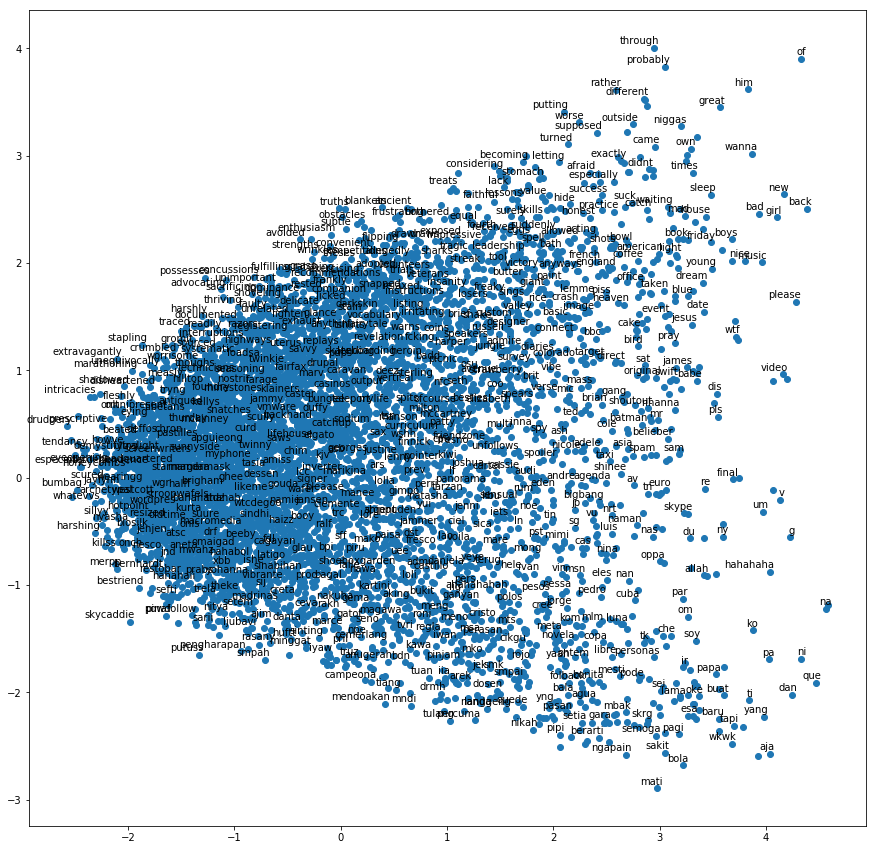

In [110]:
# plot pca
def plot(pca, labels, mapping):
    assert pca.shape[0] == len(labels), 'Labels are not from these embeddings'
    assert pca.shape[1] == 2
    
    plt.figure(figsize=(15, 15))  # in inches
    plt.scatter(pca[:, 0], pca[:, 1])
    
    x_y_array = []
    
    def get_closest(x, y):
        r = 999999
        for x_, y_ in x_y_array:
            dist = np.linalg.norm([x - x_, y - y_])
            if dist < r:
                r = dist
                
        return r
    
    for label in tqdm(labels):
        i = mapping[label]
        x, y = pca[i, :]
        if get_closest(x, y) < 0.15:
            continue
        x_y_array.append((x, y))
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

all_words = list(word_index.keys())
selected_words = np.random.choice(all_words, 10000, replace = False)
selected_word_ids = [word_index[x] for x in selected_words]
mapping = {x: y for y, x in enumerate(selected_words)}

plot(pca[selected_word_ids, :], selected_words, mapping)